# Figure 3g

In [1]:
%load_ext autoreload
%autoreload 2

In [49]:
from requirements import *
from segger.data.parquet._utils import (
    filter_transcripts,
    load_settings,
)
from sg_utils.tl.xenium_utils import anndata_from_transcripts
from sg_utils.pp.preprocess_rapids import preprocess_rapids
from sg_utils.pl.plot_embedding import plot_embedding
from sg_utils.pl.plot_volcano import plot_volcano
import anndata

## Transcripts to AnnData

*Note*: Below, I filter using 'min_counts_per_cell' = 50. 
This is fairly aggressive for Xenium data, as it removes, for instance, many 
immune cells which have lower capture levels. However, for this analysis, my
primary concern is capturing genuine epithelial cells, whose UMIs are high above
this level, and a more aggressive filtering significantly cleans the data.

In [5]:
# Read in all transcripts
transcripts = pd.read_parquet(data_dir / 'labeled_transcripts.parquet')

# Filter control probes and low QV probes
xe_settings = load_settings('xenium')
transcripts = filter_transcripts(
    transcripts,
    label=xe_settings.transcripts.label,
    filter_substrings=xe_settings.transcripts.filter_substrings,
    min_qv=30,
)

# Label epithelial transcripts
is_epithelial = transcripts['cellpose_cell_type'].eq('Epithelial/Cancer')
transcripts['is_epithelial'] = is_epithelial

In [44]:
# Segmentation columns to compare
segmentation_columns = [
    '10x_cell_id',
    '10x_nucleus_id',
    'baysor_cell_id_c=0.5',
    'baysor_cell_id_c=0.9',
    'segger_cell_id_3Q6EISGCD9',
    'segger_cell_id_HDE46PBXJB',
]

In [45]:
# Build and process AnnData for each
for seg_col in segmentation_columns:

    # Filter by cellpose epithelial labels and segger score
    gb = transcripts.groupby(seg_col)
    mask = gb['is_epithelial'].mean().gt(0.5)
    mask = transcripts[seg_col].map(mask).fillna(False)
    if 'segger' in seg_col:
        mask &= transcripts[seg_col.replace('cell_id', 'score')].gt(0.33)

    # Transcripts to anndata
    ad = anndata_from_transcripts(
        transcripts[mask],
        cell_label=seg_col,
        gene_label='feature_name',
    )
    
    # Preprocess
    preprocess_rapids(
        ad,
        filter_min_counts=50,
        pca_total_var=0.75,
        pca_layer='norm',
        knn_neighbors=20,
        phenograph_resolution=0.75,
    )
    
    # Save to file
    ad.write_h5ad(data_dir / f'h5ads/{seg_col}_epithelial.h5ad')

Done: 100%|██████████| 6/6 [00:27<00:00,  4.61s/it]         


## Contamination in Segger vs. 10X cell segmentation

In [30]:
ad_10x = sc.read_h5ad(data_dir / f'h5ads/10x_cell_id_epithelial.h5ad')
ad_seg = sc.read_h5ad(data_dir / f'h5ads/segger_cell_id_HDE46PBXJB_epithelial.h5ad')

In [31]:
ad = anndata.concat(
    [ad_seg, ad_10x],
    label='segmentation',
    keys=['Segger Embedding', '10X'],
    index_unique='-',
)

In [32]:
# Preprocess
preprocess_rapids(
    ad,
    filter_min_counts=50,
    pca_total_var=0.75,
    pca_layer='norm',
    knn_neighbors=20,
    phenograph_resolution=0.75,
)

Done: 100%|██████████| 6/6 [01:33<00:00, 15.58s/it]         


In [33]:
# Differential expression between
sc.tl.rank_genes_groups(
    ad,
    groupby='segmentation',
    use_raw=False,
    layer='lognorm',
    method='wilcoxon'
)

In [34]:
# Read in CellPose AnnData
ad_cp = sc.read_h5ad(data_dir / f'h5ads/cellpose_cell_id.h5ad')

# Gene markers to highlight
cell_types = [
    'Smooth Muscle and Pericyte', 
    'Myeloid',
    'Lymphoid',
    'Endothelial',
    'Fibroblast and Stromal',
]
highlight = dict()
for c in cell_types:
    genes = ad_cp.var.index[ad_cp.var[c + ' Marker']]
    for g in genes:
        highlight[g] = named_colors[c]

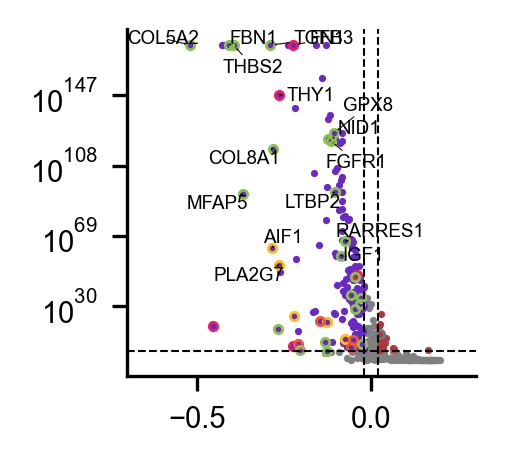

In [55]:
fig, ax = plt.subplots(1,1, figsize=(1.5, 1.5))

plot_volcano(
    ad.uns['rank_genes_groups'],
    group='Segger Embedding',
    pvals_lim=(1e-175, 1e-5),
    logfc_lim=(-0.7, 0.3),
    logfc_cutoff=0.02,
    ax=ax,
    palette=named_colors,
    highlight=highlight,
)

fig.savefig(media_dir / 'figure_3g.svg')